In [1]:
from PIL import Image
import numpy as np
import torch

from models.yolo import Model
from utils.torch_utils import intersect_dicts
import torchvision.transforms as T
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# yolov5
ckpt = torch.load('yolov5l.pt', map_location='cpu')
model = Model(ckpt['model'].yaml, ch=3, nc=80)
state_dict = ckpt['model'].float().state_dict()
state_dict = intersect_dicts(state_dict, model.state_dict(), exclude=[])
model.load_state_dict(state_dict, strict=False)

# yolov5c
ckpt_tiny = torch.load('yolov5s.pt', map_location='cpu')
model_tiny = Model(ckpt_tiny['model'].yaml, ch=3, nc=80)
state_dict_tiny = ckpt_tiny['model'].float().state_dict()
state_dict_tiny = intersect_dicts(state_dict_tiny, model_tiny.state_dict(), exclude=[])
model_tiny.load_state_dict(state_dict_tiny, strict=False)

# yolov5c distilled
ckpt_distilled = torch.load('runs/AB_distill/exp/weights_distill/last_distill.pt', map_location='cpu')
model_distilled = Model(ckpt_distilled['model'].yaml, ch=3, nc=80)
state_dict_distilled = ckpt_distilled['model'].float().state_dict()
state_dict_distilled = intersect_dicts(state_dict_distilled, model_distilled.state_dict(), exclude=[])
model_distilled.load_state_dict(state_dict_distilled, strict=False)

# yolov5c default
model_default = Model('models/yolov5c.yaml', ch=3, nc=80)


In [3]:
# define attention
import torch.nn.functional as F
import torch.nn as nn

def at_sum(x, ord):
    ret = x.abs()
    if ord == 1:
        return ret.mean(1)
    else:
        return ret.pow(ord).mean(1)
    
def at_max(x):
    ret = x.abs()
    return torch.max(ret, dim=1)[0]
    

def forward(self, x):
    inputs = x

    res1 = self.model[0:5](inputs)
    res2 = self.model[5:7](res1)
    res3 = self.model[7:10](res2)
    
    return [at_sum(res, 2) for res in [res1, res2, res3]]


Model.forward = forward

torch.Size([1, 3, 640, 640])


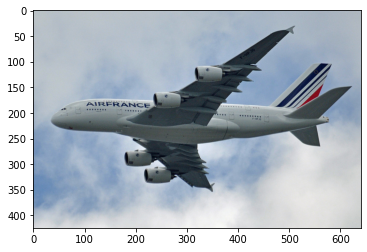

In [4]:
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor()
])

x = Image.open('data/images/plane2.jpg')
plt.imshow(x)
x = transform(x).unsqueeze(0)
print(x.size())

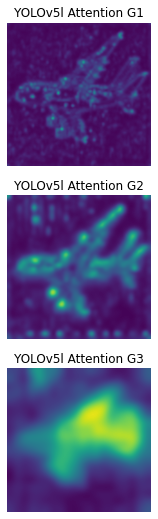

In [5]:
model.eval()
model_tiny.eval()
model_distilled.eval()
model_default.eval()
with torch.no_grad():
    gs = model(x)
    gs_tiny = model_tiny(x)
    gs_distilled = model_distilled(x)
    gs_default = model_default(x)
    
plt.figure(figsize=(4, 9))

for i, g in enumerate(gs, 0):
    plt.subplot(3, 1, i+1)
    plt.axis('off')
    plt.imshow(g[0], interpolation='bicubic')
    plt.title(f'YOLOv5l Attention G{i+1}')
    
# for i, g in enumerate(gs_tiny, 0):
#     plt.subplot(3, 4, i*4+2)
#     plt.axis('off')
#     plt.imshow(g[0], interpolation='bicubic')
#     plt.title(f'yolov5s G{i+1}')
    
# for i, g in enumerate(gs_distilled, 0):
#     plt.subplot(3, 4, i*4+3)
#     plt.axis('off')
#     plt.imshow(g[0], interpolation='bicubic')
#     plt.title(f'yolov5c distilled G{i+1}')
    
# for i, g in enumerate(gs_default, 0):
#     plt.subplot(3, 4, i*4+4)
#     plt.axis('off')
#     plt.imshow(g[0], interpolation='bicubic')
#     plt.title(f'yolov5c default G{i+1}')

plt.savefig('figures/attention.png')
plt.show()